In [24]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

from IPython.display import Image 

## 군집화 란?
- 비지도 학습의 대표적인 기술로 레이블이 지정되어 있지 않은 데이터를 그룹화하는 알고리즘
- 데이터의 특성을 고려해 데이터 집단을 정의하고 데이터 집단의 대표할 수 있는 중심점들을 찾음

## 1. K-means
- 군집 중심점이라는 특정한 임의의 지점을 선택해 해당 중심에 가장 가까운 포인트들을 선택하는 방법
- 선택된 포인트의 평균 지점으로 이동하고 이동된 중심정에서 가장 가까운 포인트를 선택

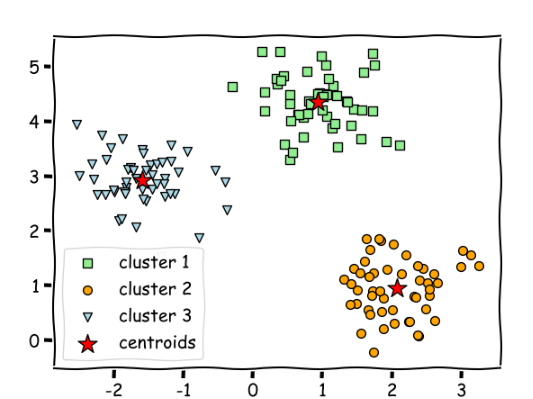

In [6]:
Image("img/k-means.png")

### 장점
- 일반적으로 군집화에서 가장 많이 사용되는 알고리즘
- 알고리즘이 쉽고 간결

### 단점
- 거리 기반 알고리즘으로 속성의 개수가 매우 많을 수록 정확도가 떨어짐
- 반복을 수행하는데 반복횟수가 많을 경우 매우 느려짐
- 몇개의 군집을 선택해야할 지 가이드하기가 어려움

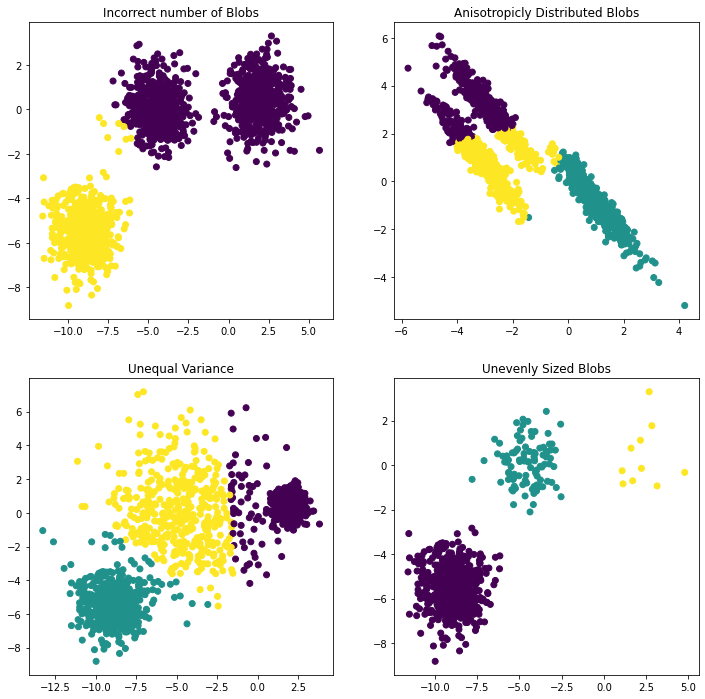

In [2]:
plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.title("Incorrect number of Blobs")

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

X_filtered = np.vstack((X[y==0][:500], X[y==1][:100], X[y==2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

### Mini Batch K-Means

기존 K-means 방법에서는 데이터의 개수가 많아지면 계산량도 늘어나기에 데이터의 개수가 너무 많을 때는 미니배치를 사용해 데이터의 크기를 줄이고 K-means 군집화를 진행함

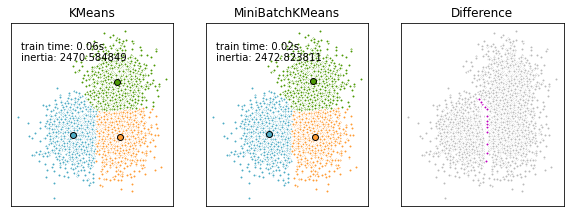

In [4]:
np.random.seed(0)

batch_size = 45
centers = [[1, 1,], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

## 2. DBSCAN

- DBSCAN 군집화 방법은 데이터가 밀집한 정도 즉 밀도를 이용함
- DBSCAN 군집화는 군집의 형태에 구애받지 않으며 군집의 갯수를 사용자가 지정할 필요가 없음
- 초기 데이터로부터 근접한 데이터를 찾아나가는 방법으로 군집을 확장 

    1. 최소 거리 : 이웃을 정의하기 위한 거리
    2. 최소 데이터 갯수 : 밀집지역을 정의하기 위해 필요한 이웃의 개수

- 최소 거리 안의 이웃 영역 안에 최소 데이터 갯수 이상의 데이터가 있으면 이 데이터는 핵심 데이터라고 한다. 

DBSCAN 클래스에서 사용하는 인수

    - eps : 이웃을 정의하기 위한 거리
    - min_samples : 핵심 데이터를 정의하기 위해 필요한 이웃 영역 안의 데이터 개수

군집화 속성

     - labels_ : 군집 번호
     - core_sample_indices_ : 핵심 데이터의 인덱스 여기에 포함되지 않고 아웃라이어도 아닌 데이터는 경계 데이터

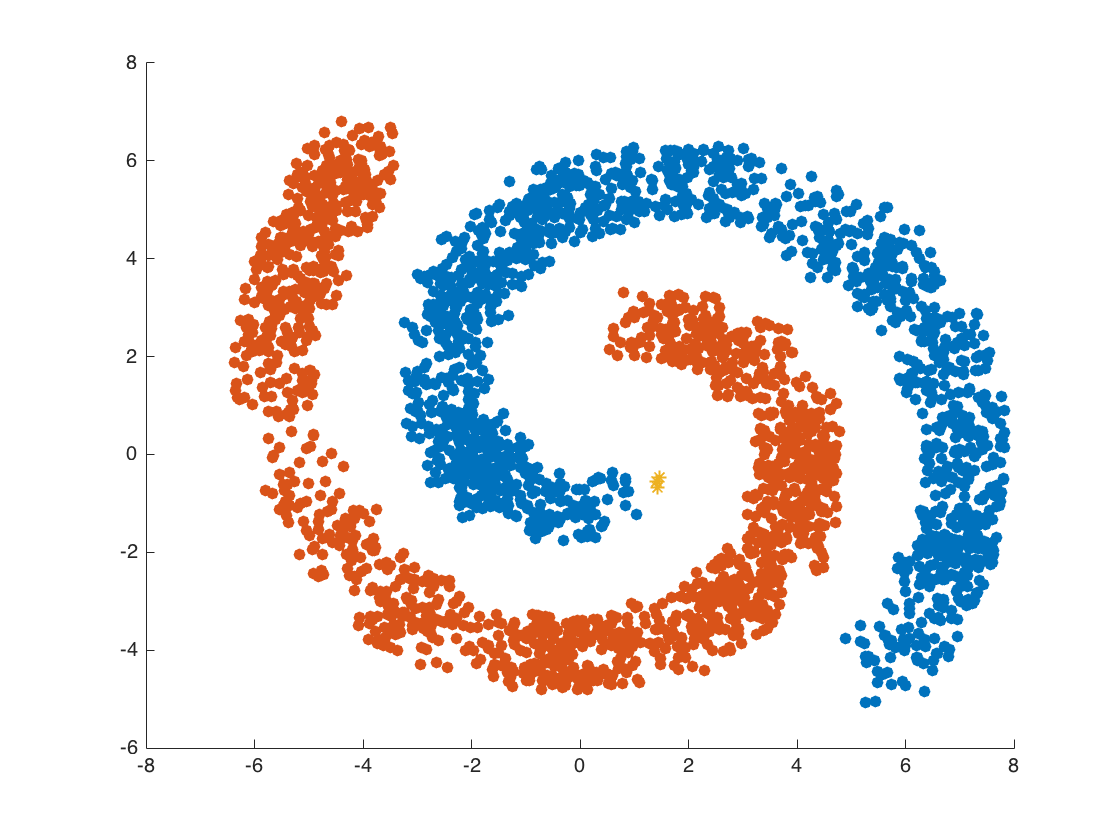

In [26]:
Image("img/dbscan.png")

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44400 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52488 missing from c

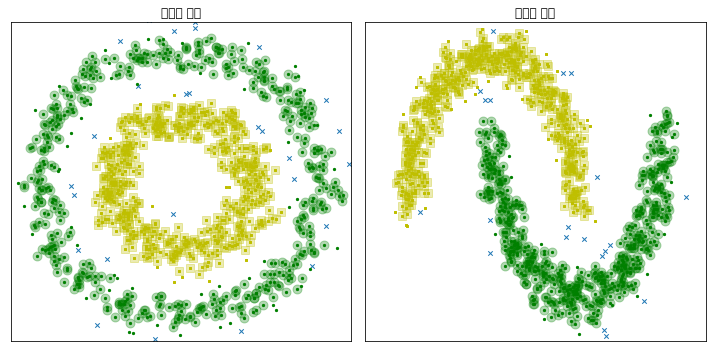

In [8]:
from sklearn.datasets import make_circles, make_moons
from sklearn.cluster import DBSCAN

n_samples = 1000
np.random.seed(2)
X1, y1 = make_circles(n_samples=n_samples, factor=.5, noise=.09)
X2, y2 = make_moons(n_samples=n_samples, noise=.1)

def plot_DBSCAN(title, X, eps, xlim, ylim):
    model = DBSCAN(eps=eps)
    y_pred = model.fit_predict(X)
    idx_outlier = model.labels_ == -1
    plt.scatter(X[idx_outlier, 0], X[idx_outlier, 1], marker='x', lw=1, s=20)
    plt.scatter(X[model.labels_ == 0, 0], X[model.labels_ == 0, 1], marker='o', facecolor='g', s=5)
    plt.scatter(X[model.labels_ == 1, 0], X[model.labels_ == 1, 1], marker='s', facecolor='y', s=5)
    X_core = X[model.core_sample_indices_, :]
    idx_core_0 = np.array(list(set(np.where(model.labels_ == 0)[0]).intersection(model.core_sample_indices_)))
    idx_core_1 = np.array(list(set(np.where(model.labels_ == 1)[0]).intersection(model.core_sample_indices_)))
    plt.scatter(X[idx_core_0, 0], X[idx_core_0, 1], marker='o', facecolor='g', s=80, alpha=0.3)
    plt.scatter(X[idx_core_1, 0], X[idx_core_1, 1], marker='s', facecolor='y', s=80, alpha=0.3)
    plt.grid(False)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    return y_pred

plt.figure(figsize=(10, 5))
plt.subplot(121)
y_pred1 = plot_DBSCAN("동심원 군집", X1, 0.1, (-1.2, 1.2), (-1.2, 1.2))
plt.subplot(122)
y_pred2 = plot_DBSCAN("초승달 군집", X2, 0.1, (-1.5, 2.5), (-0.8, 1.2))
plt.tight_layout()
plt.show()

## 3. 계층적 군집화

- 여러 개의 군집 중에서 가장 유사도가 높은 혹은 거리가 가까운 군집 두개를 선택하여 하나로 합치면서 군집 개수를 줄여가는 방법
- 최초에는 데이터 개수만큼 군집이 존재하다가 군집을 합치면서 최종적으로 하나의 군집만 남음

### 군집 간의 거리 측정

- 군집 간 거리를 측정하기 위해서는 계층적 방법과 비계층적 방법 2가지가 존재

### 비계층적 거리 측정법

- 계층적 군집화가 아니더라도 모든 경우에 사용할 수 있는 거리 측정 방법
- 중심거리, 단일거리, 완전거리, 평균거리 존재

### 계층적 거리 측정법

- 이전 단계에서 이미 어떤 두 개의 군집이 하나로 합쳐진 적이 있다고 가정하여 이 정보를 사용함
- 중앙값 거리, 가중 거리 존재

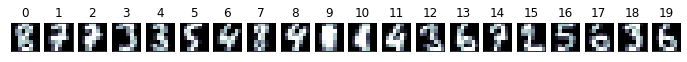

In [9]:
from sklearn.datasets import load_digits

digits = load_digits()
n_image = 20
np.random.seed(0)
idx = np.random.choice(range(len(digits.images)), n_image)
X = digits.data[idx]
images = digits.images[idx]

plt.figure(figsize=(12, 1))
for i in range(n_image):
    plt.subplot(1, n_image, i + 1)
    plt.imshow(images[i], cmap=plt.cm.bone)
    plt.grid(False)
    plt.xticks(())
    plt.yticks(())
    plt.title(i)

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X, 'ward')
Z

array([[ 3.        , 18.        , 23.51595203,  2.        ],
       [13.        , 19.        , 25.27844932,  2.        ],
       [ 1.        , 14.        , 28.67054237,  2.        ],
       [17.        , 21.        , 31.04298096,  3.        ],
       [ 4.        ,  7.        , 31.51190251,  2.        ],
       [ 6.        ,  8.        , 32.54228019,  2.        ],
       [ 9.        , 10.        , 33.36165464,  2.        ],
       [ 0.        , 24.        , 34.51086785,  3.        ],
       [ 2.        , 22.        , 37.03151811,  3.        ],
       [11.        , 26.        , 43.25505751,  3.        ],
       [12.        , 15.        , 45.31004304,  2.        ],
       [16.        , 20.        , 45.36151085,  3.        ],
       [ 5.        , 27.        , 53.54437412,  4.        ],
       [30.        , 32.        , 56.6892112 ,  6.        ],
       [25.        , 29.        , 60.16809786,  5.        ],
       [28.        , 34.        , 66.61618922,  8.        ],
       [31.        , 33.

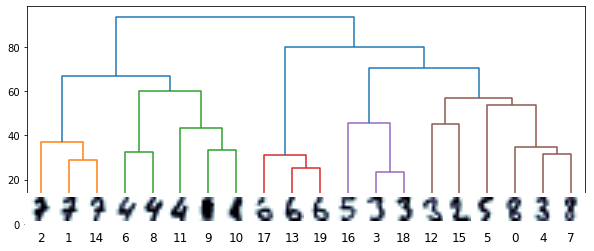

In [12]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(10, 4))
ax = plt.subplot()

ddata = dendrogram(Z)

dcoord = np.array(ddata["dcoord"])
icoord = np.array(ddata["icoord"])
leaves = np.array(ddata["leaves"])
idx = np.argsort(dcoord[:, 2])
dcoord = dcoord[idx, :]
icoord = icoord[idx, :]
idx = np.argsort(Z[:, :2].ravel())
label_pos = icoord[:, 1:3].ravel()[idx][:20]

for i in range(20):
    imagebox = OffsetImage(images[i], cmap=plt.cm.bone_r, interpolation="bilinear", zoom=3)
    ab = AnnotationBbox(imagebox, (label_pos[i], 0),  box_alignment=(0.5, -0.1), 
                        bboxprops={"edgecolor" : "none"})
    ax.add_artist(ab)

plt.show()

## 4. Affinity Propagation

- 모든 데이터가 특정한 기준에 따라 자신을 대표할 대표 데이터를 선택한다. 만약 스스로가 자기를 대표하면 클러스터의 중심이 됨
    
    - responsibility r(i, k)
        - k 번째 데이터가 i번째 데이터의 대표가 되어야 한다는 근거
    
    - availability a(i, k)
        - i번째 데이터가 k번째 데이터를 대표로 선택해야 한다는 근거
    
    - responsibility와 availability를 모두 0으로 놓고 다음 수식을 수렴할 때까지 반복

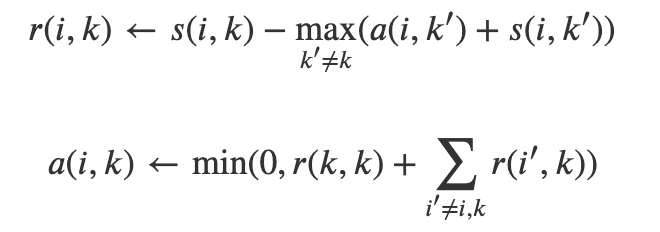

In [13]:
Image("img/affinity_1.png")

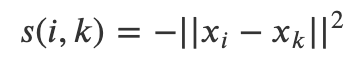

In [14]:
Image("img/affinity_2.png")

- s(k, k)는 특정한 음수 값으로 사용자가 정해주게 되는데 이 값에 따라서 클러스터의 갯수가 달라지는 하이퍼 모수가 됨
- s(k, k)가 크면 자기 자신에 대한 유사도가 커져서 클러스터의 수가 증가함

In [16]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import *

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5, random_state=0)

model = AffinityPropagation(preference=-50).fit(X)

cluster_centers_indices = model.cluster_centers_indices_
labels = model.labels_
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


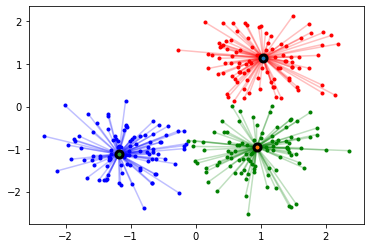

In [17]:
from itertools import cycle

colors = cycle('rgb')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, alpha=0.25)
    plt.plot(cluster_center[0], cluster_center[1], 'o', mec='k', mew=3, markersize=7)

plt.show()

## 5. 평균이동(Mean Shift)

- K 평균과 유사하지만 거리 중심이 아니라 데이터가 모여있는 밀도가 가장 높은 쪽으로 군집 중심점을 이동하면서 군집화를 수행함
- 일반 업무 기반의 정형 데이터 세트보다 컴퓨터 비전 영역에서 이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는데 뛰어난 역할을 수행하는 알고리즘
- 이러한 특성 때문에 업무 기반의 데이터 세트보다는 컴퓨터 비전 영역에서 잘 사용됨

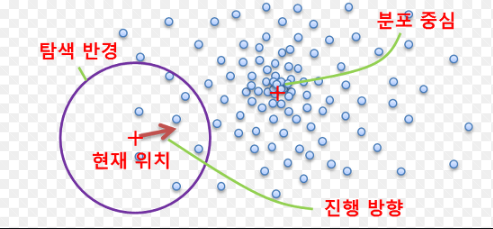

In [18]:
Image("img/mean_shift.png")

### 장점
- 데이터 세트의 형태를 특정 형태로 가정한다던가, 특정 분포도 기반의 모델로 가정하지 않기 때문에 좀 더 유연한 군집화 가능
- 이상치의 영향력이 크지 않음
- 미리 군집의 개수 정할 필요 없음

### 단점
- 알고리즘의 수행시간이 오래 걸림
- Bandwidth의 크기에 따른 군집화 영향도가 매우 큼

In [19]:
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

# 클러스터 3개인 가상데이터
X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

# Mean Shift
meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)

print(f"Mean Shift Cluster 유형: {np.unique(cluster_labels)}")

Mean Shift Cluster 유형: [0 1 2 3 4 5]


In [20]:
# Mean Shift
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)

print(f"Mean Shift Cluster 유형: {np.unique(cluster_labels)}")

Mean Shift Cluster 유형: [0 1 2]


In [21]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


In [22]:
# 최적 bandwidth
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth = best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('best bandwidth cluster labels 유형:',np.unique(cluster_labels))

best bandwidth cluster labels 유형: [0 1 2]


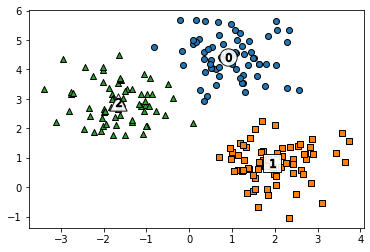

In [25]:
# 데이터 프레임 생성
cluster_df = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
cluster_df['target'] = y
cluster_df["meanshift_label"] = cluster_labels

# 클러스터별 중심 위치 좌표
centers = meanshift.cluster_centers_

# cluster 값 종류
unique_labels = np.unique(cluster_labels)

markers=['o', 's', '^', 'P','D','H','x']

for cluster in unique_labels:
    
    # 각 군집 시각화
    cluster_v = cluster_df[cluster_df['meanshift_label'] == cluster]    
    plt.scatter(x=cluster_v['ftr1'], y=cluster_v['ftr2'], edgecolor='k', marker=markers[cluster] )
    
    # 군집별 중심 위치 시각화
    center_xy = centers[cluster]
    
    plt.scatter(x = center_xy[0], y = center_xy[1], s=300, color='white',
                alpha=0.9, edgecolor='k', marker = markers[cluster])
    
    plt.scatter(x = center_xy[0], y = center_xy[1], s=70, color='k', 
                edgecolor='k', marker = f"${cluster}$")
    
    
plt.show()

## 6. GMM(Gaussian Mixture Model)

- GMM 군집화는 군집화를 적용하는 데이터가 여러 개의 가우시안 분포 모델을 섞어서 생성된 모델로 가정해 수행하는 방식

### 가우시안 분포란?

- 좌우 대칭형의 bell 형태를 가진 통계학에서 가장 잘 알려진 연속확률함수

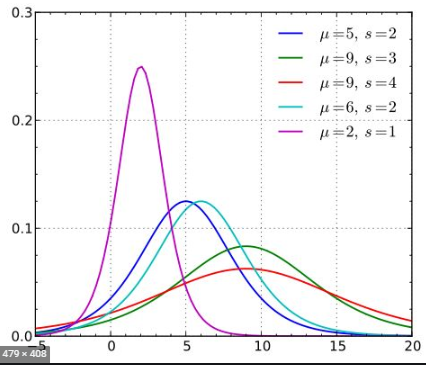

In [27]:
Image("img/gaussian.png")

- GMM은 데이터를 여러개의 가우시안 분포가 섞인것으로 간주 ---> 섞인 데이터 분포에서 개별 유형의 가우시안 분포를 추출한다. 
- 전체 데이터 세트는 서로 다른 정규분포를 가진 여러가지 확률 분포 곡선으로 구성되어 있으며, 정규분포에 기반에 군집화를 수행하는 것이 GMM 군집화 방식
- 일정한 데이터 세트가 있으면 이를 구성하는 여러개의 정규 분포 곡선 추출 뒤, 개별 데이터가 이 중 어떤 정규분포에 속하는지 결정 
- 이러한 방식을 모수추정이라고 하며 "개별 정규 분포의 평균과 분산", "각 데이터가 어떤 정규 분포에 해당되는지의 확률"을 구하기 위해서 추정한다 
- GMM은 모수추정을 하기 위해 EM(Expectation and Maximization)방법을 적용하고 있따. 

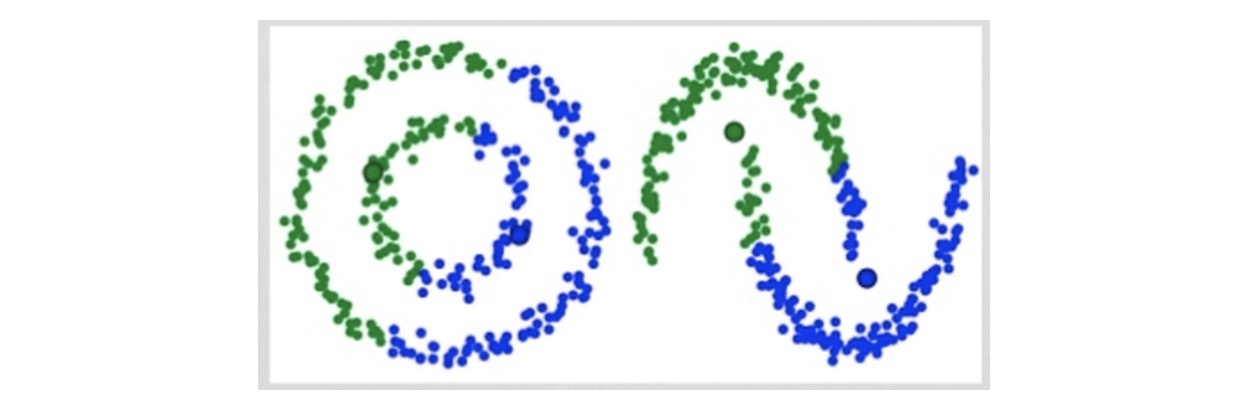

In [28]:
Image("img/gaussian_1.png")